In [104]:
import numpy as np
import math
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt

In [105]:
class Option_param():
    """
    Option class wants the option parameters:
    S0 = current stock price
    K = Strike price
    T = time to maturity
    
    exercise = European or American
    """
    def __init__(self, S0=100, K=100, T=1, payoff="call", exercise="European"):
        self.S0 = S0
        self.K = K
        self.T = T
        self.Delta = None
        self.Gamma = None
        self.Theta = None
        self.Vega = None
        self.Rho = None
        
        if (exercise=="European" or exercise=="American"):
            self.exercise = exercise
        else: 
            raise ValueError("invalid type. Set 'European' or 'American'")
        
        if (payoff=="call" or payoff=="put"):
            self.payoff = payoff
        else: 
            raise ValueError("invalid type. Set 'call' or 'put'")


In [106]:
class Diffusion_process():
    """
    Class for the diffusion process:
    r = continuously compounded risk-free interest rate (% p.a.)
    q = continuously compounded dividend yield (% p.a.)
    sig = volatility (% p.a.)
    """
    def __init__(self, r=0.1, q=0.0, sig=0.2):
        self.r = r
        if (q<0):
            raise ValueError("Dividend must be positive")
        else:
            self.q = q
            
        if (sig<=0):
            raise ValueError("sig must be positive")
        else:
            self.sig = sig

    def exp_RV(self, S0, T, N):
        W = ss.norm.rvs( (self.r-0.5*self.sig**2)*T , np.sqrt(T)*self.sig, N)
        S_T = S0 * np.exp(W)
        return S_T

In [107]:
class Option_pricer():
    
    def __init__(self, Option_info, Process_info ):
        """
        Process_info:  of type Diffusion_process. It contains (r,mu, sig) i.e.  interest rate, drift coefficient, diffusion coefficient
    
        Option_info:  of type Option_param. It contains (S0,K,T) i.e. current price, strike, maturity in years
        """
        self.r = Process_info.r           # interest rate
        self.q = Process_info.q
        self.sig = Process_info.sig       # diffusion coefficient
        self.S0 = Option_info.S0          # current price
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity in years
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
        
        
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
    
    
    def Binomial_Tree(self, N=10000):
        dT = float(self.T) / N                             # Delta t
        u = np.exp(self.sig * np.sqrt(dT))                 # up factor
        d = 1.0 / u                                   # down factor 

        V = np.zeros(N+1)                             # initialize the price vector
        S_T = np.array( [(self.S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

        a = np.exp((self.r - self.q ) * dT)    # risk free compound return
        p = (a - d)/ (u - d)  # risk neutral up probability
        q = 1.0 - p           # risk neutral down probability   

        if self.payoff =="call":
            V[:] = np.maximum(S_T-self.K, 0.0)
        elif self.payoff =="put":
            V[:] = np.maximum(self.K-S_T, 0.0)
        else: raise ValueError("invalid type. Set 'call' or 'put'")

        
        if self.exercise == "American":
            for i in range(N-1, -1, -1):
                V[:-1] = np.exp(-self.r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
                S_T = S_T * u                    # it is a tricky way to obtain the price at the previous time step
                if self.payoff=="call":
                    V = np.maximum( V, S_T-self.K )
                elif self.payoff=="put":
                    V = np.maximum( V, self.K-S_T )

            return ("American", V[0])
            
        elif self.exercise == "European":
            for i in range(N-1, -1, -1):
                V[:-1] = np.exp(-self.r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step

            return ("European",  V[0])
        
        else: raise ValueError("invalid type. Set 'American' or 'European'")
    
    
    def Monte_Carlo_Simulation(self, N=10000, paths=10000, order=2):
        """
        Monte Carlo Simulation for pricing American options
        
        N = number of time steps
        paths = number of generated paths
        order = order of the polynomial for the regression 
        """
        dt = self.T/(N-1)          # time interval
        df = np.exp(-self.r * dt)  # discount factor per time time interval

        X0 = np.zeros((paths,1))
        increments = ss.norm.rvs(loc=(self.r - self.q - self.sig**2/2)*dt, scale=np.sqrt(dt)*self.sig, size=(paths,N-1))
        X = np.concatenate((X0,increments), axis=1).cumsum(1)
        S = self.S0 * np.exp(X)
        
        if self.exercise == "American":
            if self.payoff =="put":
                H = np.maximum(self.K - S, 0)   # intrinsic values for put option
                V = np.zeros_like(H)            # value matrix
                V[:,-1] = H[:,-1]

                # Valuation by Monte Carlo Simulation
                for t in range(N-2, 0, -1):
                    good_paths = H[:,t] > 0    
                    rg = np.polyfit( S[good_paths, t], V[good_paths, t+1] * df, order)    # polynomial regression
                    C = np.polyval( rg, S[good_paths,t] )                             # evaluation of regression  

                    exercise = np.zeros( len(good_paths), dtype=bool)
                    exercise[good_paths] = H[good_paths,t] > C

                    V[exercise,t] = H[exercise,t]
                    V[exercise,t+1:] = 0
                    discount_path = (V[:,t] == 0)
                    V[discount_path,t] = V[discount_path,t+1] * df

                V0 = np.mean(V[:,1]) * df  # 
                return ("American" , V0)

            elif self.payoff =="call":
                H = np.maximum(S - self.K, 0)   # intrinsic values for put option
                V = np.zeros_like(H)            # value matrix
                V[:,-1] = H[:,-1]

                # Valuation by Monte Carlo Simulation
                for t in range(N-2, 0, -1):
                    good_paths = H[:,t] > 0  
                    if t==N-2: type(good_paths)
                    rg = np.polyfit( S[good_paths, t], V[good_paths, t+1] * df, order)    # polynomial regression
                    C = np.polyval( rg, S[good_paths,t] )                             # evaluation of regression  

                    exercise = np.zeros( len(good_paths), dtype=bool)
                    exercise[good_paths] = H[good_paths,t] > C

                    V[exercise,t] = H[exercise,t]
                    V[exercise,t+1:] = 0
                    discount_path = (V[:,t] == 0)
                    V[discount_path,t] = V[discount_path,t+1] * df

                V0 = np.mean(V[:,1]) * df  # 
                return("American" , V0)

            else: raise ValueError("invalid type. Set 'call' or 'put'")
    
        elif self.exercise == "European":
            if self.payoff =="put":
                H = np.maximum(self.K - S, 0)   # intrinsic values for put option
                V = np.zeros_like(H)            # value matrix
                V[:,-1] = H[:,-1]

                # Valuation by Monte Carlo Simulation
                for t in range(N-2, 0, -1):
                    V[:,t] = V[:,t+1] * df

                V0 = np.mean(V[:,1]) * df  # 
                return("European" , V0)   

            elif self.payoff =="call":
                H = np.maximum(S - self.K, 0)   # intrinsic values for put option
                V = np.zeros_like(H)            # value matrix
                V[:,-1] = H[:,-1]

                # Valuation by Monte Carlo Simulation
                for t in range(N-2, 0, -1):
                    V[:,t] = V[:,t+1] * df

                V0 = np.mean(V[:,1]) * df  # 
                return("European" , V0)

            else: raise ValueError("invalid type. Set 'call' or 'put'")

        else: raise ValueError("invalid type. Set 'American' or 'European'")
    
    
    
    def Black_Scholes(self):
        """ Black Scholes closed formula:
            payoff: call or put.
            S0: float.    initial stock/index level.
            K: float strike price.
            T: float maturity (in year fractions).  
            r: float constant risk-free short rate.
            sigma: volatility factor in diffusion term. """
   
        d1 = (np.log(self.S0/self.K) + (self.r - self.q + self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))
        d2 = (np.log(self.S0/self.K) + (self.r - self.q - self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))

        if self.payoff=='call':
            return ("European", self.S0 * np.exp(-self.q * self.T) * ss.norm.cdf( d1 ) - self.K * np.exp(-self.r * self.T) * ss.norm.cdf( d2 ))
        elif self.payoff=='put':
            return ("European", self.K * np.exp(-self.r * self.T) * ss.norm.cdf( -d2 ) - self.S0 * np.exp(-self.q * self.T) * ss.norm.cdf( -d1 ))
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
            
            
            
    def plot(self): 
        
        if self.exercise == "European":
            fig, axs = plt.subplots(2, figsize=(10,10))
            fig.tight_layout(pad = 7)

            K = np.arange(self.K*0.1,self.K*1.9, self.K*0.1)
            if self.payoff == "call":
                payoff = np.array(np.maximum(self.S0-K, 0))
            if self.payoff == "put":
                payoff = np.array(np.maximum(K-self.S0, 0))
            axs[0].plot(K, payoff, label = "exercise price at S0")


            price = np.array([])
            for k in np.arange(self.K*0.1,self.K*1.9, self.K*0.1):
                opt_param = Option_param(S0=self.S0, K=k, T=self.T, exercise=self.exercise, payoff=self.payoff)
                diff_param = Diffusion_process(r=self.r, sig=self.sig)
                option = Option_pricer(opt_param, diff_param)
                price = np.append(price, option.Black_Scholes()[1])

            axs[0].plot(K, price, label = "Black_Scholes Pricing")
            axs[0].set_title("Spot price = " + str(self.S0))
            axs[0].set(xlabel = "Strike price (K)", ylabel = "Option Value")
            axs[0].legend()



            S0 = np.arange(self.S0*0.1,self.S0*1.9, self.S0*0.1)
            if self.payoff == "call":
                payoff = np.array(np.maximum(S0-self.K, 0))
            if self.payoff == "put":
                payoff = np.array(np.maximum(self.K-S0, 0))
            axs[1].plot(S0, payoff, label = "exercise price at S0")


            price = np.array([])
            for S in np.arange(self.S0*0.1,self.S0*1.9, self.S0*0.1):
                opt_param = Option_param(S0=S, K=self.K, T=self.T, exercise=self.exercise, payoff=self.payoff)
                diff_param = Diffusion_process(r=self.r, sig=self.sig)
                option = Option_pricer(opt_param, diff_param)
                price = np.append(price, option.Black_Scholes()[1])

            axs[1].plot(S0, price, label = "Black_Scholes Pricing")
            axs[1].set_title("Strike price = " + str(self.S0))
            axs[1].set(xlabel = "Spot price (S0)", ylabel = "Option Value")
            axs[1].legend()
        
        elif self.exercise == "American":
            fig, axs = plt.subplots(2, figsize=(10,10))
            fig.tight_layout(pad = 7)

            K = np.arange(self.K*0.1,self.K*1.9, self.K*0.1)
            if self.payoff == "call":
                payoff = np.array(np.maximum(self.S0-K, 0))
            if self.payoff == "put":
                payoff = np.array(np.maximum(K-self.S0, 0))
            axs[0].plot(K, payoff, label = "exercise price at S0")


            price = np.array([])
            for k in np.arange(self.K*0.1,self.K*1.9, self.K*0.1):
                opt_param = Option_param(S0=self.S0, K=k, T=self.T, exercise=self.exercise, payoff=self.payoff)
                diff_param = Diffusion_process(r=self.r, sig=self.sig)
                option = Option_pricer(opt_param, diff_param)
                price = np.append(price, option.Binomial_Tree()[1])

            axs[0].plot(K, price, label = "Binomial_Tree Pricing")
            axs[0].set_title("Spot price = " + str(self.S0))
            axs[0].set(xlabel = "Strike price (K)", ylabel = "Option Value")
            axs[0].legend()



            S0 = np.arange(self.S0*0.1,self.S0*1.9, self.S0*0.1)
            if self.payoff == "call":
                payoff = np.array(np.maximum(S0-self.K, 0))
            if self.payoff == "put":
                payoff = np.array(np.maximum(self.K-S0, 0))
            axs[1].plot(S0, payoff, label = "exercise price at S0")


            price = np.array([])
            for S in np.arange(self.S0*0.1,self.S0*1.9, self.S0*0.1):
                opt_param = Option_param(S0=S, K=self.K, T=self.T, exercise=self.exercise, payoff=self.payoff)
                diff_param = Diffusion_process(r=self.r, sig=self.sig)
                option = Option_pricer(opt_param, diff_param)
                price = np.append(price, option.Binomial_Tree()[1])

            axs[1].plot(S0, price, label = "Binomial_Tree Pricing")
            axs[1].set_title("Strike price = " + str(self.S0))
            axs[1].set(xlabel = "Spot price (S0)", ylabel = "Option Value")
            axs[1].legend()
            
        
        else: raise ValueError("invalid type. Set 'American' or 'European'")
            
    
    
    def greeks(self):
        d1 = (np.log(self.S0/self.K) + (self.r - self.q + self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))
        d2 = (np.log(self.S0/self.K) + (self.r - self.q - self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))
        
        if self.payoff == "call":
            self.Delta = np.exp(-self.q * self.T) * ss.norm.cdf(d1)
            self.Gamma = (np.exp(-self.q * self.T - (d1**2)/2))/(self.S0 * self.sig * np.sqrt(self.T) * np.sqrt(2 * math.pi))
            self.Theta = (1/(self.T*365)) * (-((self.S0 * self.sig * np.exp(-self.q * self.T - (d1**2)/2))/(2 * np.sqrt(2 * self.T * math.pi))) - self.r * self.K * np.exp(-self.r * self.T) * ss.norm.cdf(d2) + self.q * self.S0 * np.exp(-self.q * self.T) * ss.norm.cdf(d1))
            self.Vega  = (1/100) * self.S0 * np.exp(-self.q * self.T - (d1**2)/2) * np.sqrt(self.T) * (1/np.sqrt(2 * math.pi))   
            self.Rho   = (1/100) * self.K * self.T * np.exp(-self.r * self.T) * ss.norm.cdf(d2)
        
        elif self.payoff == "put":
            self.Delta = np.exp(-self.q * self.T) * (ss.norm.cdf(d1)-1)
            self.Gamma = (np.exp(-self.q * self.T - (d1**2)/2))/(self.S0 * self.sig * np.sqrt(self.T) * np.sqrt(2 * math.pi))
            self.Theta = (1/(self.T*365)) * (-((self.S0 * self.sig * np.exp(-self.q * self.T - (d1**2)/2))/(2 * np.sqrt(2 * self.T * math.pi))) + self.r * self.K * np.exp(-self.r * self.T) * ss.norm.cdf(-d2) - self.q * self.S0 * np.exp(-self.q * self.T) * ss.norm.cdf(-d1))
            self.Vega  = (1/100) * self.S0 * np.exp(-self.q * self.T - (d1**2)/2) * np.sqrt(self.T) * (1/np.sqrt(2 * math.pi))  
            self.Rho   = (-1/100) * self.K * self.T * np.exp(-self.r * self.T) * ss.norm.cdf(-d2)
        
        else: raise ValueError("invalid type. Set 'call' or 'put'")
        
        print("Delta: ", self.Delta)
        print("Gamma: ", self.Gamma)
        print("Theta: ", self.Theta)
        print("Vega: " , self.Vega )
        print("Rho: "  , self.Rho  )
        print("\n")
    

In [108]:
def implied_vol(payoff, option_price, S0, K, T, r, q):
    # apply bisection method to get the implied volatility by solving the BSM function
    precision = 0.00001
    upper_vol = 500.0
    lower_vol = 0.0001
    iteration = 0
    
    opt_param = Option_param(S0=S0, K=K, T=T, exercise="European", payoff=payoff)
    diff_param = Diffusion_process(r=r, q=q, sig=250.0)
    option = Option_pricer(opt_param, diff_param)

    while 1:
        iteration +=1
        mid_vol = (upper_vol + lower_vol)/2.0
        option.sig = mid_vol
        price = option.Black_Scholes()[1]
        if payoff == "call":
            option.sig = lower_vol
            lower_price = option.Black_Scholes()[1]
            if (lower_price - option_price) * (price - option_price) > 0:
                lower_vol = mid_vol
            else:
                upper_vol = mid_vol
            if abs(price - option_price) < precision: break 
            if iteration > 100: raise ValueError("Computational error occured. ")

        elif payoff == "put":
            option.sig = upper_vol
            upper_price = option.Black_Scholes()[1]
            if (upper_price - option_price) * (price - option_price) > 0:
                upper_vol = mid_vol
            else:
                lower_vol = mid_vol
            if abs(price - option_price) < precision: break 
            if iteration > 100: raise ValueError("Computational error occured. ")

    return mid_vol

In [109]:
def greeks_hedge (*option):
    """
    if Delta is being hedged:      number of options needed = Number of hedged Greeks
    if Delta is not being hedged:  number of options needed = Number of hedged Greeks + 1
    """  
    num_option = 0
    for opt in option:
        num_option += 1
        print("Option",num_option,":")
        opt.greeks()
        
    number = ['first', 'second', 'thirth', 'fourth', 'fifth']
    
    num_greeks = int(input("How many greeks are going to hedge: "))
    greeks = [np.array([],dtype = str)]
    for n in range(num_greeks):
        greeks = np.append(greeks, input("The " + number[n] + " hedging greek: "))
    
    
    stock_Delta = np.array([1])
    array_Delta = np.append(stock_Delta, [option[index].Delta for index in range(num_option-1)])
    stock_Gamma = np.array([0])
    array_Gamma = np.append(stock_Gamma, [option[index].Gamma for index in range(num_option-1)])
    stock_Theta = np.array([0])
    array_Theta = np.append(stock_Theta, [option[index].Theta for index in range(num_option-1)])
    stock_Vega  = np.array([0])
    array_Vega  = np.append(stock_Vega , [option[index].Vega  for index in range(num_option-1)])
    stock_Rho = np.array([0])
    array_Rho   = np.append(stock_Rho  , [option[index].Rho   for index in range(num_option-1)])
    
    matrix_Left  = np.array([])
    matrix_Right = np.array([])
    
    for g in greeks:
        if g == "Delta":
            matrix_Left  = np.append(matrix_Left, array_Delta)
            matrix_Right = np.append(matrix_Right, -option[-1].Delta)
        if g == "Gamma":
            matrix_Left  = np.append(matrix_Left, array_Gamma)
            matrix_Right = np.append(matrix_Right, -option[-1].Gamma)
        if g == "Theta":
            matrix_Left  = np.append(matrix_Left, array_Theta)
            matrix_Right = np.append(matrix_Right, -option[-1].Theta)
        if g == "Vega":
            matrix_Left  = np.append(matrix_Left, array_Vega)
            matrix_Right = np.append(matrix_Right, -option[-1].Vega)
        if g == "Rho":
            matrix_Left  = np.append(matrix_Left, array_Rho)
            matrix_Right = np.append(matrix_Right, -option[-1].Rho)
        
        
    matrix_Left.shape = (num_greeks,num_option)
    x = np.linalg.lstsq(matrix_Left, matrix_Right)
    result = np.append(x[0],1)
    for i in range(num_option+1):
        if i==0: 
            print("\nPortfolio: ")
            print("Stock     : ", result[i])
        else:
            print("Option ",i,": ", result[i])

    
    
    matrix_greeks = np.array([np.append(array_Delta, option[-1].Delta), np.append(array_Gamma, option[-1].Gamma), np.append(array_Theta, option[-1].Theta), np.append(array_Vega, option[-1].Vega), np.append(array_Rho, option[-1].Rho)])
    portfolio_greeks = matrix_greeks.dot(result)
    print("\nThe Portfolio's Greeks: ")
    print("Delta: ", portfolio_greeks[0])
    print("Gamma: ", portfolio_greeks[1])
    print("Theta: ", portfolio_greeks[2])
    print("Vega : ", portfolio_greeks[3])
    print("Rho  : ", portfolio_greeks[4])
    
    
    
    
    

In [110]:
implied_vol(payoff="call", option_price=5.17174691, S0=100, K=110, T=1, r=0.13, q=0.09)

0.1999999687580392

In [111]:
implied_vol(payoff="put", option_price=0.10336389, S0=100, K=70, T=1, r=0.13, q=0.02)

0.21991443538814784

In [112]:
implied_vol(payoff="call", option_price=6.0128267, S0=100, K=110, T=1, r=0.13, q=0.07)

0.20028961002081633

In [113]:
# Creates the option_1
opt_param = Option_param(S0=100, K=110, T=1, exercise="European", payoff="call")
diff_param = Diffusion_process(r=0.13, q=0.09, sig=0.2)
option_1 = Option_pricer(opt_param, diff_param)

In [114]:
# Creates the option_2
opt_param = Option_param(S0=100, K=70, T=1, exercise="European", payoff="put")
diff_param = Diffusion_process(r=0.13, q=0.02, sig=0.22)
option_2 = Option_pricer(opt_param, diff_param)

In [115]:
# Creates the option_3
opt_param = Option_param(S0=100, K=110, T=1, exercise="European", payoff="call")
diff_param = Diffusion_process(r=0.13, q=0.07, sig=0.2)
option_3 = Option_pricer(opt_param, diff_param)

In [116]:
option_1.Binomial_Tree()

('European', 5.17173982431996)

In [117]:
option_1.Monte_Carlo_Simulation()

('European', 5.296825291527466)

In [118]:
option_1.Black_Scholes()

('European', 5.171746910724259)

In [119]:
option_2.Binomial_Tree()

('European', 0.10361881912995327)

In [120]:
option_2.Monte_Carlo_Simulation()

('European', 0.11649074315647964)

In [121]:
option_2.Black_Scholes()

('European', 0.10363892841819022)

In [122]:
option_3.Binomial_Tree()

('European', 6.002053141851009)

In [123]:
option_3.Monte_Carlo_Simulation()

('European', 5.992604805106601)

In [124]:
option_3.Black_Scholes()

('European', 6.002075719878697)

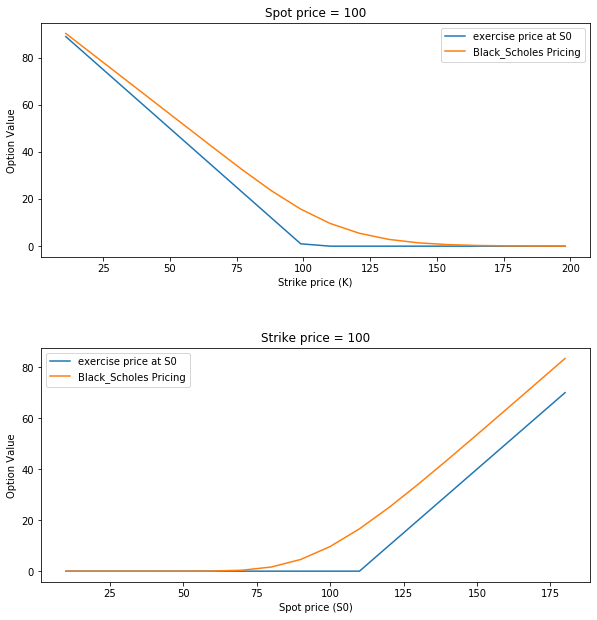

In [125]:
option_1.plot()

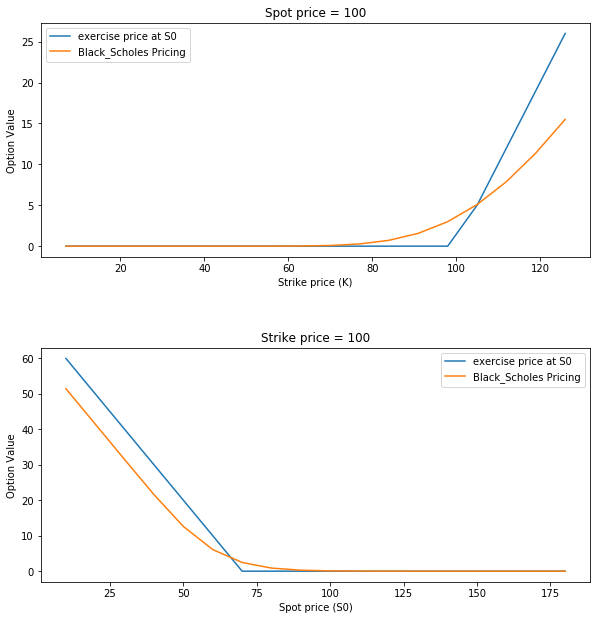

In [126]:
option_2.plot()

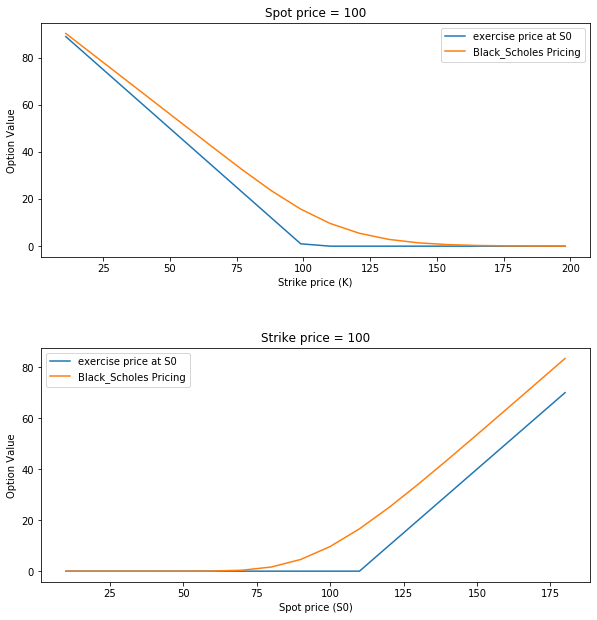

In [127]:
option_3.plot()

In [141]:
greeks_hedge(option_1,option_2,option_3)

Option 1 :
Delta:  0.39292696684251743
Gamma:  0.01794837106324773
Theta:  -0.01229878077157661
Vega:  0.35896742126495457
Rho:  0.34120949773527487


Option 2 :
Delta:  -0.012578198789316201
Gamma:  0.0014748209310516587
Theta:  -0.0005618449806511207
Vega:  0.03244606048313649
Rho:  -0.013614588073498057


Option 3 :
Delta:  0.43774995733591904
Gamma:  0.01854415142268068
Theta:  -0.015219342972513475
Vega:  0.37088302845361354
Rho:  0.37772920013713207


How many greeks are going to hedge: 3
The first hedging greek: Delta
The second hedging greek: Theta
The thirth hedging greek: Rho

Portfolio: 
Stock     :  0.001956661742301191
Option  1 :  -1.1678427311703725
Option  2 :  -1.5240880948644884
Option  3 :  1.0

The Portfolio's Greeks: 
Delta:  0.0
Gamma:  -0.004664480282954627
Theta:  -4.336808689942018e-17
Vega :  -0.09778511970523812
Rho  :  5.551115123125783e-17


/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
